/tmp/ipykernel_158280/1510954880.py:60: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_lon = ds_tmp.dims['lon']
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires

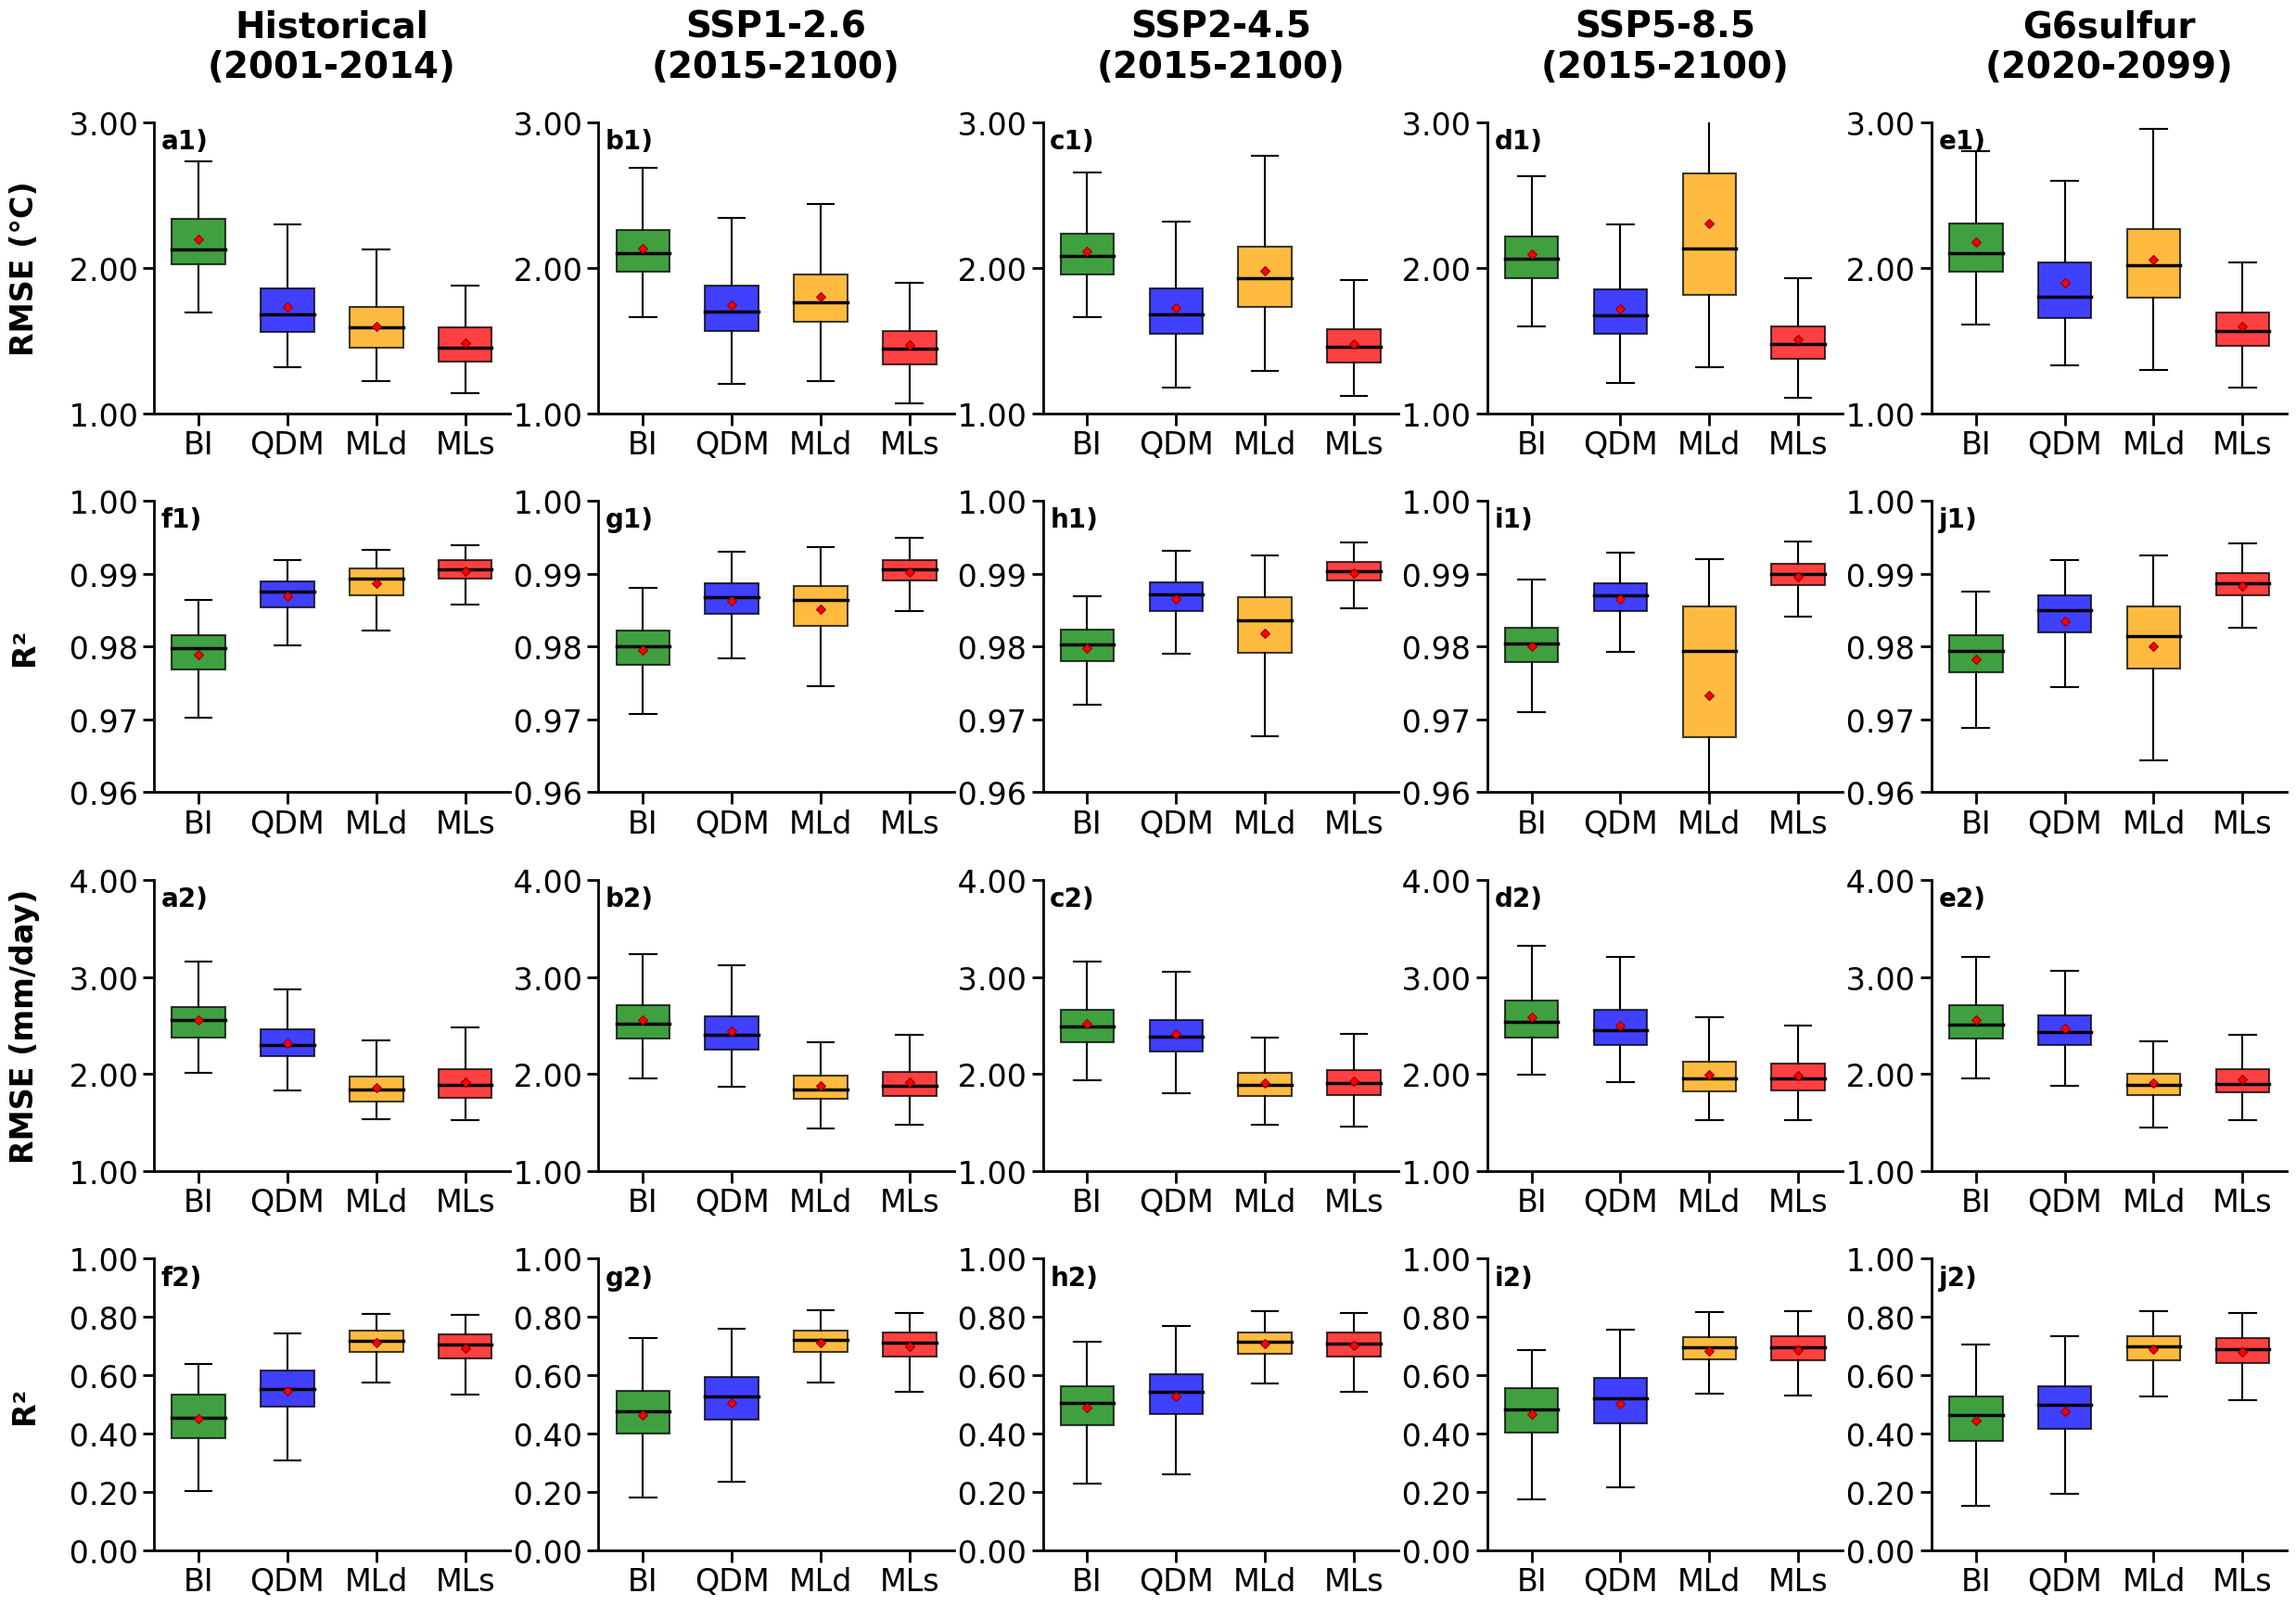

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from joblib import Parallel, delayed

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

variables = ['tas', 'pr']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']

models = {
    'bilinear': 'BI',
    'qdm': 'QDM',
    'zs_p': 'MLd',      
    'pld_res': 'MLs'
}

scenario_labels = {
    'historical': 'Historical\n(2001-2014)',
    'ssp126': 'SSP1-2.6\n(2015-2100)',
    'ssp245': 'SSP2-4.5\n(2015-2100)',
    'g6sulfur': 'G6sulfur\n(2020-2099)',
    'ssp585': 'SSP5-8.5\n(2015-2100)'
}

var_units = {
    'tas': '°C',
    'pr': 'mm/day'
}

model_colors = {
    'bilinear': 'green',    
    'qdm': 'blue',        
    'zs_p': 'orange',        
    'pld_res': 'red'      
}

y_axis_config = {
    'tas': {
        'rmse': {'lim': (1, 3), 'ticks': [1, 2, 3]},
        'r2': {'lim': (0.96, 1), 'ticks': [0.96, 0.97, 0.98, 0.99, 1.0]}
    },
    'pr': {
        'rmse': {'lim': (1, 4), 'ticks': [1, 2, 3, 4]},
        'r2': {'lim': (0.0, 1), 'ticks': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}
    }
}

# ----------------------------
# Compute latitude weights
# ----------------------------
ds_tmp = xr.open_dataset(results_dir / "tas_evaluation_historical.nc")
lats = ds_tmp['lat'].values
n_lon = ds_tmp.dims['lon']
ds_tmp.close()

lat_weights_2d = np.cos(np.deg2rad(lats))[:, np.newaxis] * np.ones((1, n_lon))  # (192, 384)
w_total = np.sum(lat_weights_2d)

# ----------------------------
# Vectorized functions
# ----------------------------
def compute_spatial_rmse_timeseries(predictions, groundtruth):
    diff_sq = (predictions - groundtruth)**2  # (time, 192, 384)
    weighted = diff_sq * lat_weights_2d[np.newaxis, :, :]
    return np.sqrt(np.sum(weighted, axis=(1, 2)) / w_total)

def compute_spatial_r2_timeseries(predictions, groundtruth):
    w = lat_weights_2d[np.newaxis, :, :]  # (1, 192, 384)
    weighted_mean = np.sum(w * groundtruth, axis=(1, 2), keepdims=True) / w_total
    ss_res = np.sum(w * (groundtruth - predictions)**2, axis=(1, 2))
    ss_tot = np.sum(w * (groundtruth - weighted_mean)**2, axis=(1, 2))
    return np.where(ss_tot > 0, 1 - ss_res / ss_tot, 0.0)

# ----------------------------
# Parallel loading function
# ----------------------------
def load_and_compute(var, scenario):
    results = {}
    
    main_file = results_dir / f"{var}_evaluation_{scenario}.nc"
    if main_file.exists():
        ds = xr.open_dataset(main_file)
        gt = ds['groundtruth'].values
        
        if 'input' in ds:
            inp = ds['input'].values
            results['bilinear'] = {
                'rmse': compute_spatial_rmse_timeseries(inp, gt),
                'r2': compute_spatial_r2_timeseries(inp, gt)
            }
        
        if 'pred_zscore_pixel' in ds:
            pred = ds['pred_zscore_pixel'].values
            results['zs_p'] = {
                'rmse': compute_spatial_rmse_timeseries(pred, gt),
                'r2': compute_spatial_r2_timeseries(pred, gt)
            }
        ds.close()
    
    qdm_file = results_dir / f"{var}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds = xr.open_dataset(qdm_file)
        gt = ds['groundtruth'].values
        if 'pred_qdm' in ds:
            pred = ds['pred_qdm'].values
            results['qdm'] = {
                'rmse': compute_spatial_rmse_timeseries(pred, gt),
                'r2': compute_spatial_r2_timeseries(pred, gt)
            }
        ds.close()
    
    res_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
    if res_file.exists():
        ds = xr.open_dataset(res_file)
        gt = ds['groundtruth'].values
        if 'pred_grid' in ds:
            pred = ds['pred_grid'].values
            results['pld_res'] = {
                'rmse': compute_spatial_rmse_timeseries(pred, gt),
                'r2': compute_spatial_r2_timeseries(pred, gt)
            }
        ds.close()
    
    return var, scenario, results

# ----------------------------
# Run in parallel
# ----------------------------
tasks = [(var, scenario) for var in variables for scenario in scenarios]
parallel_results = Parallel(n_jobs=min(len(tasks), 20), verbose=1)(
    delayed(load_and_compute)(var, scenario) for var, scenario in tasks
)

metrics_rmse = {var: {scen: {} for scen in scenarios} for var in variables}
metrics_r2 = {var: {scen: {} for scen in scenarios} for var in variables}

for var, scenario, results in parallel_results:
    for model_key, metric_dict in results.items():
        metrics_rmse[var][scenario][model_key] = metric_dict['rmse']
        metrics_r2[var][scenario][model_key] = metric_dict['r2']

# ----------------------------
# Create 4x5 visualization
# ----------------------------
fig, axes = plt.subplots(4, 5, figsize=(25, 20))

row_config = [
    ('rmse', 'tas'),
    ('r2', 'tas'),
    ('rmse', 'pr'),
    ('r2', 'pr')
]

letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

for row, (metric_type, var) in enumerate(row_config):
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        
        if var == 'tas':
            panel_label = f"{letters[row * 5 + col]}1"
        else:
            panel_label = f"{letters[(row - 2) * 5 + col]}2"
        
        if metric_type == 'rmse':
            metrics = metrics_rmse
            ylabel = f'RMSE ({var_units[var]})'
            y_config = y_axis_config[var]['rmse']
        else:
            metrics = metrics_r2
            ylabel = 'R²'
            y_config = y_axis_config[var]['r2']
        
        box_data = []
        positions = []
        colors = []
        labels = []
        
        for i, (model_key, model_name) in enumerate(models.items()):
            if model_key in metrics[var][scenario]:
                box_data.append(metrics[var][scenario][model_key])
                positions.append(i + 1)
                colors.append(model_colors[model_key])
                labels.append(model_name)
        
        if len(box_data) > 0:
            bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                            patch_artist=True, showfliers=False,
                            medianprops=dict(color='black', linewidth=2.5),
                            boxprops=dict(linewidth=1.5),
                            whiskerprops=dict(linewidth=1.5),
                            capprops=dict(linewidth=1.5))
            
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.75)
            
            for i, data_values in enumerate(box_data):
                mean_val = np.mean(data_values)
                ax.plot(positions[i], mean_val, 'D', color='red', 
                       markersize=5, zorder=10, markeredgecolor='darkred', 
                       markeredgewidth=0.8)
        
        ax.text(0.02, 0.98, f'{panel_label})', 
               transform=ax.transAxes, fontsize=20, fontweight='bold',
               va='top', ha='left')
        
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, fontsize=24)
        
        ax.set_ylim(y_config['lim'])
        ax.set_yticks(y_config['ticks'])
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:+.2f}'.replace('+', ' ')))
        
        if col == 0:
            ax.set_ylabel(ylabel, fontsize=24, fontweight='bold', labelpad=15)
        
        if row == 0:
            ax.set_title(scenario_labels[scenario], fontsize=28, fontweight='bold', pad=35)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        ax.tick_params(axis='both', which='major', labelsize=24, length=9, width=2, colors='black')

plt.subplots_adjust(hspace=0.3, wspace=0.25, left=0.06, right=0.98)

output_file = figures_dir / "spatial_metrics.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# old

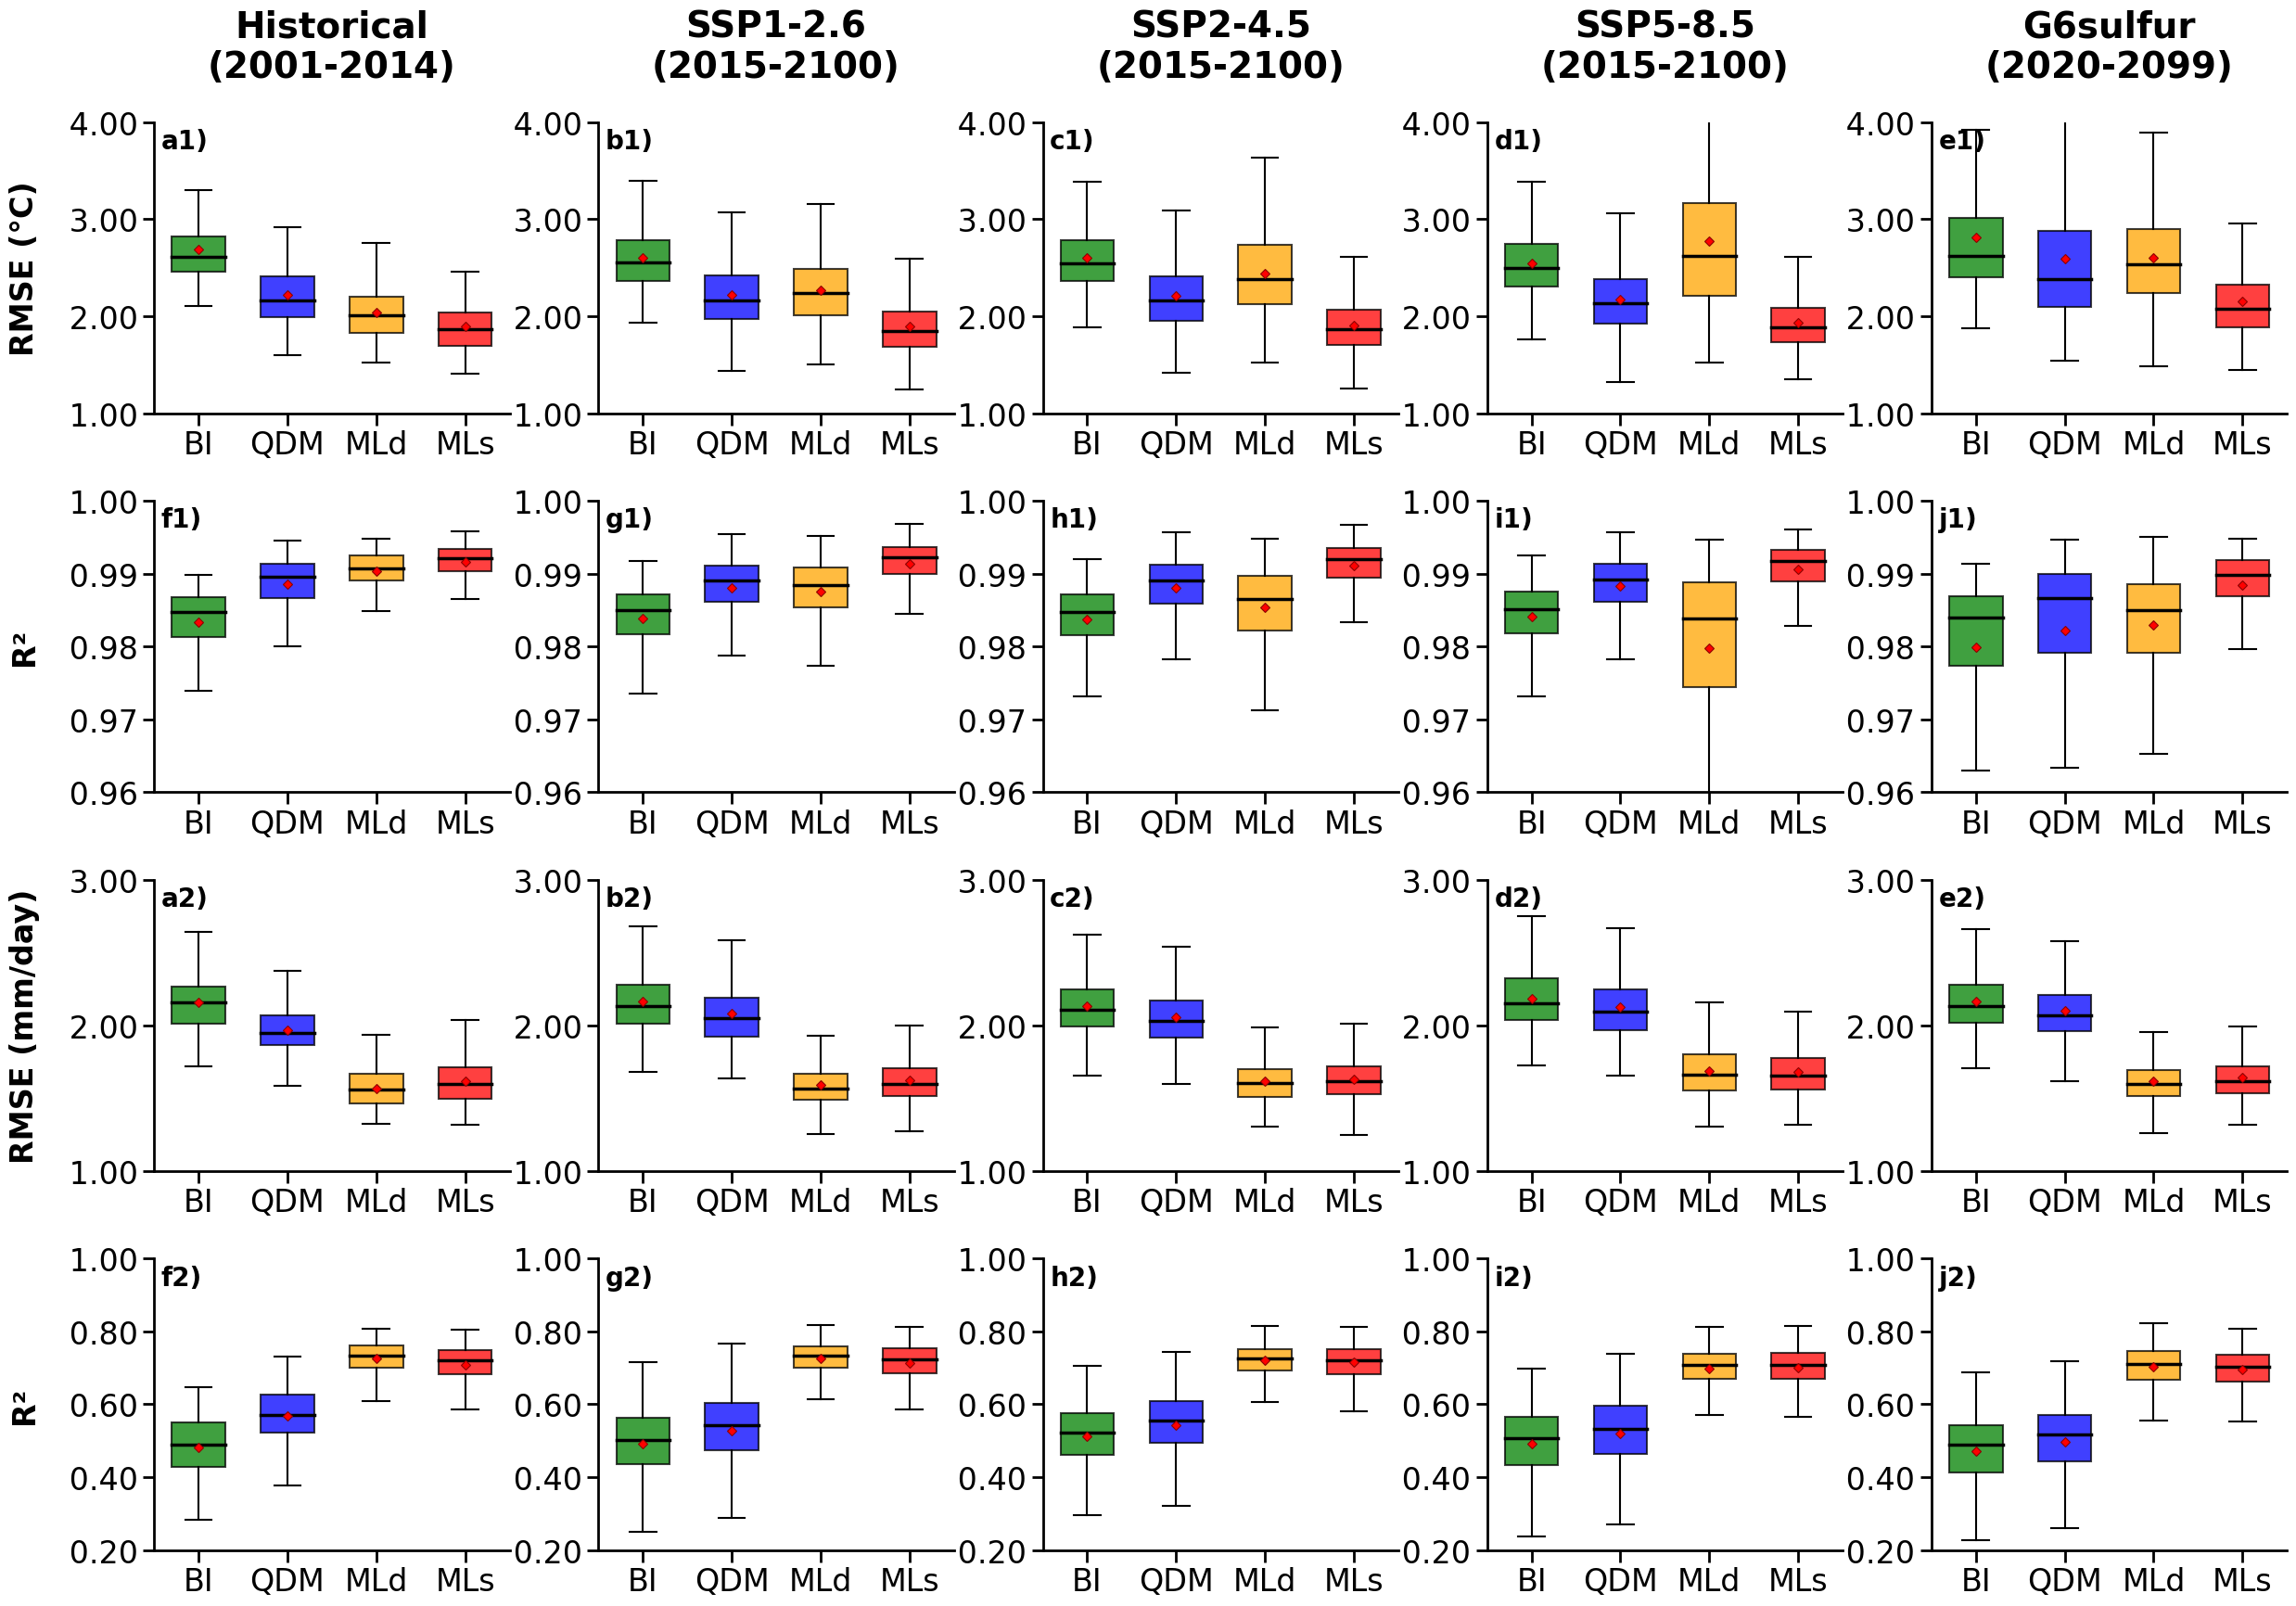

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

variables = ['tas', 'pr']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']

# Model configurations
models = {
    'bilinear': 'BI',
    'qdm': 'QDM',
    'zs_p': 'MLd',      
    'pld_res': 'MLs'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical\n(2001-2014)',
    'ssp126': 'SSP1-2.6\n(2015-2100)',
    'ssp245': 'SSP2-4.5\n(2015-2100)',
    'g6sulfur': 'G6sulfur\n(2020-2099)',
    'ssp585': 'SSP5-8.5\n(2015-2100)'
}

# Units for RMSE
var_units = {
    'tas': '°C',
    'pr': 'mm/day'
}

# Colors for models
model_colors = {
    'bilinear': 'green',    
    'qdm': 'blue',        
    'zs_p': 'orange',        
    'pld_res': 'red'      
}

# Y-axis configuration
y_axis_config = {
    'tas': {
        'rmse': {'lim': (1, 4), 'ticks': [1, 2, 3, 4]},
        'r2': {'lim': (0.96, 1), 'ticks': [0.96, 0.97, 0.98, 0.99, 1.0]}
    },
    'pr': {
        'rmse': {'lim': (1, 3), 'ticks': [1, 2, 3]},
        'r2': {'lim': (0.2, 1), 'ticks': [0.2, 0.4, 0.6, 0.8, 1.0]}
    }
}

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_rmse_timeseries(predictions, groundtruth):
    """Calculate spatial RMSE for each time point."""
    n_time = predictions.shape[0]
    rmse_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
    
    return np.array(rmse_values)

def compute_spatial_r2_timeseries(predictions, groundtruth):
    """Calculate spatial R² for each time point."""
    n_time = predictions.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        ss_res = np.sum((gt_2d - pred_2d)**2)
        ss_tot = np.sum((gt_2d - np.mean(gt_2d))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# ----------------------------
# Load data and compute metrics
# ----------------------------
# Storage: metrics[var][scenario][model] = timeseries
metrics_rmse = {var: {scen: {} for scen in scenarios} for var in variables}
metrics_r2 = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    for scenario in scenarios:
        # Load main results (for bilinear and MLd)
        main_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        if main_file.exists():
            ds_main = xr.open_dataset(main_file)
            gt_data = ds_main['groundtruth'].values
            
            # Bilinear (input)
            if 'input' in ds_main:
                input_data = ds_main['input'].values
                metrics_rmse[var][scenario]['bilinear'] = compute_spatial_rmse_timeseries(input_data, gt_data)
                metrics_r2[var][scenario]['bilinear'] = compute_spatial_r2_timeseries(input_data, gt_data)
            
            # MLd (zscore_pixel) - Changed back to zscore_pixel
            if 'pred_zscore_pixel' in ds_main:
                pred_data = ds_main['pred_zscore_pixel'].values
                metrics_rmse[var][scenario]['zs_p'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
                metrics_r2[var][scenario]['zs_p'] = compute_spatial_r2_timeseries(pred_data, gt_data)
            
            ds_main.close()
        
        # Load QDM results
        qdm_file = results_dir / f"{var}_evaluation_{scenario}_qdm.nc"
        if qdm_file.exists():
            ds_qdm = xr.open_dataset(qdm_file)
            gt_data = ds_qdm['groundtruth'].values
            
            if 'pred_qdm' in ds_qdm:
                pred_data = ds_qdm['pred_qdm'].values
                metrics_rmse[var][scenario]['qdm'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
                metrics_r2[var][scenario]['qdm'] = compute_spatial_r2_timeseries(pred_data, gt_data)
            
            ds_qdm.close()
        
        # Load residual results (for MLs)
        residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if residual_file.exists():
            ds_residual = xr.open_dataset(residual_file)
            gt_data = ds_residual['groundtruth'].values
            
            if 'pred_grid' in ds_residual:
                pred_data = ds_residual['pred_grid'].values
                metrics_rmse[var][scenario]['pld_res'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
                metrics_r2[var][scenario]['pld_res'] = compute_spatial_r2_timeseries(pred_data, gt_data)
            
            ds_residual.close()

# ----------------------------
# Create 4x5 visualization
# ----------------------------
fig, axes = plt.subplots(4, 5, figsize=(25, 20))

# Row configuration: (metric_type, variable)
# First two rows: tas (RMSE, R²), Last two rows: pr (RMSE, R²)
row_config = [
    ('rmse', 'tas'),  # Row 0: RMSE for temperature
    ('r2', 'tas'),    # Row 1: R² for temperature
    ('rmse', 'pr'),   # Row 2: RMSE for precipitation
    ('r2', 'pr')      # Row 3: R² for precipitation
]

# Panel labels: a1-j1 for tas, a2-j2 for pr
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

for row, (metric_type, var) in enumerate(row_config):
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        
        # Determine panel label
        if var == 'tas':
            panel_label = f"{letters[row * 5 + col]}1"
        else:
            panel_label = f"{letters[(row - 2) * 5 + col]}2"
        
        # Select appropriate metrics and config
        if metric_type == 'rmse':
            metrics = metrics_rmse
            ylabel = f'RMSE ({var_units[var]})'
            y_config = y_axis_config[var]['rmse']
        else:
            metrics = metrics_r2
            ylabel = 'R²'
            y_config = y_axis_config[var]['r2']
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        labels = []
        
        for i, (model_key, model_name) in enumerate(models.items()):
            if model_key in metrics[var][scenario]:
                box_data.append(metrics[var][scenario][model_key])
                positions.append(i + 1)
                colors.append(model_colors[model_key])
                labels.append(model_name)
        
        # Create box plot
        if len(box_data) > 0:
            bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                            patch_artist=True, showfliers=False,
                            medianprops=dict(color='black', linewidth=2.5),
                            boxprops=dict(linewidth=1.5),
                            whiskerprops=dict(linewidth=1.5),
                            capprops=dict(linewidth=1.5))
            
            # Color the boxes
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.75)
            
            # Add mean marker (red diamond)
            for i, data_values in enumerate(box_data):
                mean_val = np.mean(data_values)
                ax.plot(positions[i], mean_val, 'D', color='red', 
                       markersize=5, zorder=10, markeredgecolor='darkred', 
                       markeredgewidth=0.8)
        
        # Add panel label
        ax.text(0.02, 0.98, f'{panel_label})', 
               transform=ax.transAxes, fontsize=20, fontweight='bold',
               va='top', ha='left')
        
        # Formatting
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, fontsize=24)

        
        ax.set_ylim(y_config['lim'])
        ax.set_yticks(y_config['ticks'])
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:+.2f}'.replace('+', ' ')))
        
        # Y-axis label on leftmost column
        if col == 0:
            ax.set_ylabel(ylabel, fontsize=24, fontweight='bold', labelpad=15)
        
        # Scenario title on top row only
        if row == 0:
            ax.set_title(scenario_labels[scenario], fontsize=28, fontweight='bold', pad=35)
        
        # Spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        ax.tick_params(axis='both', which='major', labelsize=24, length=9, width=2, colors='black')

plt.subplots_adjust(hspace=0.3, wspace=0.25, left=0.06, right=0.98)

# Save figure
output_file = figures_dir / "spatial_metrics.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()


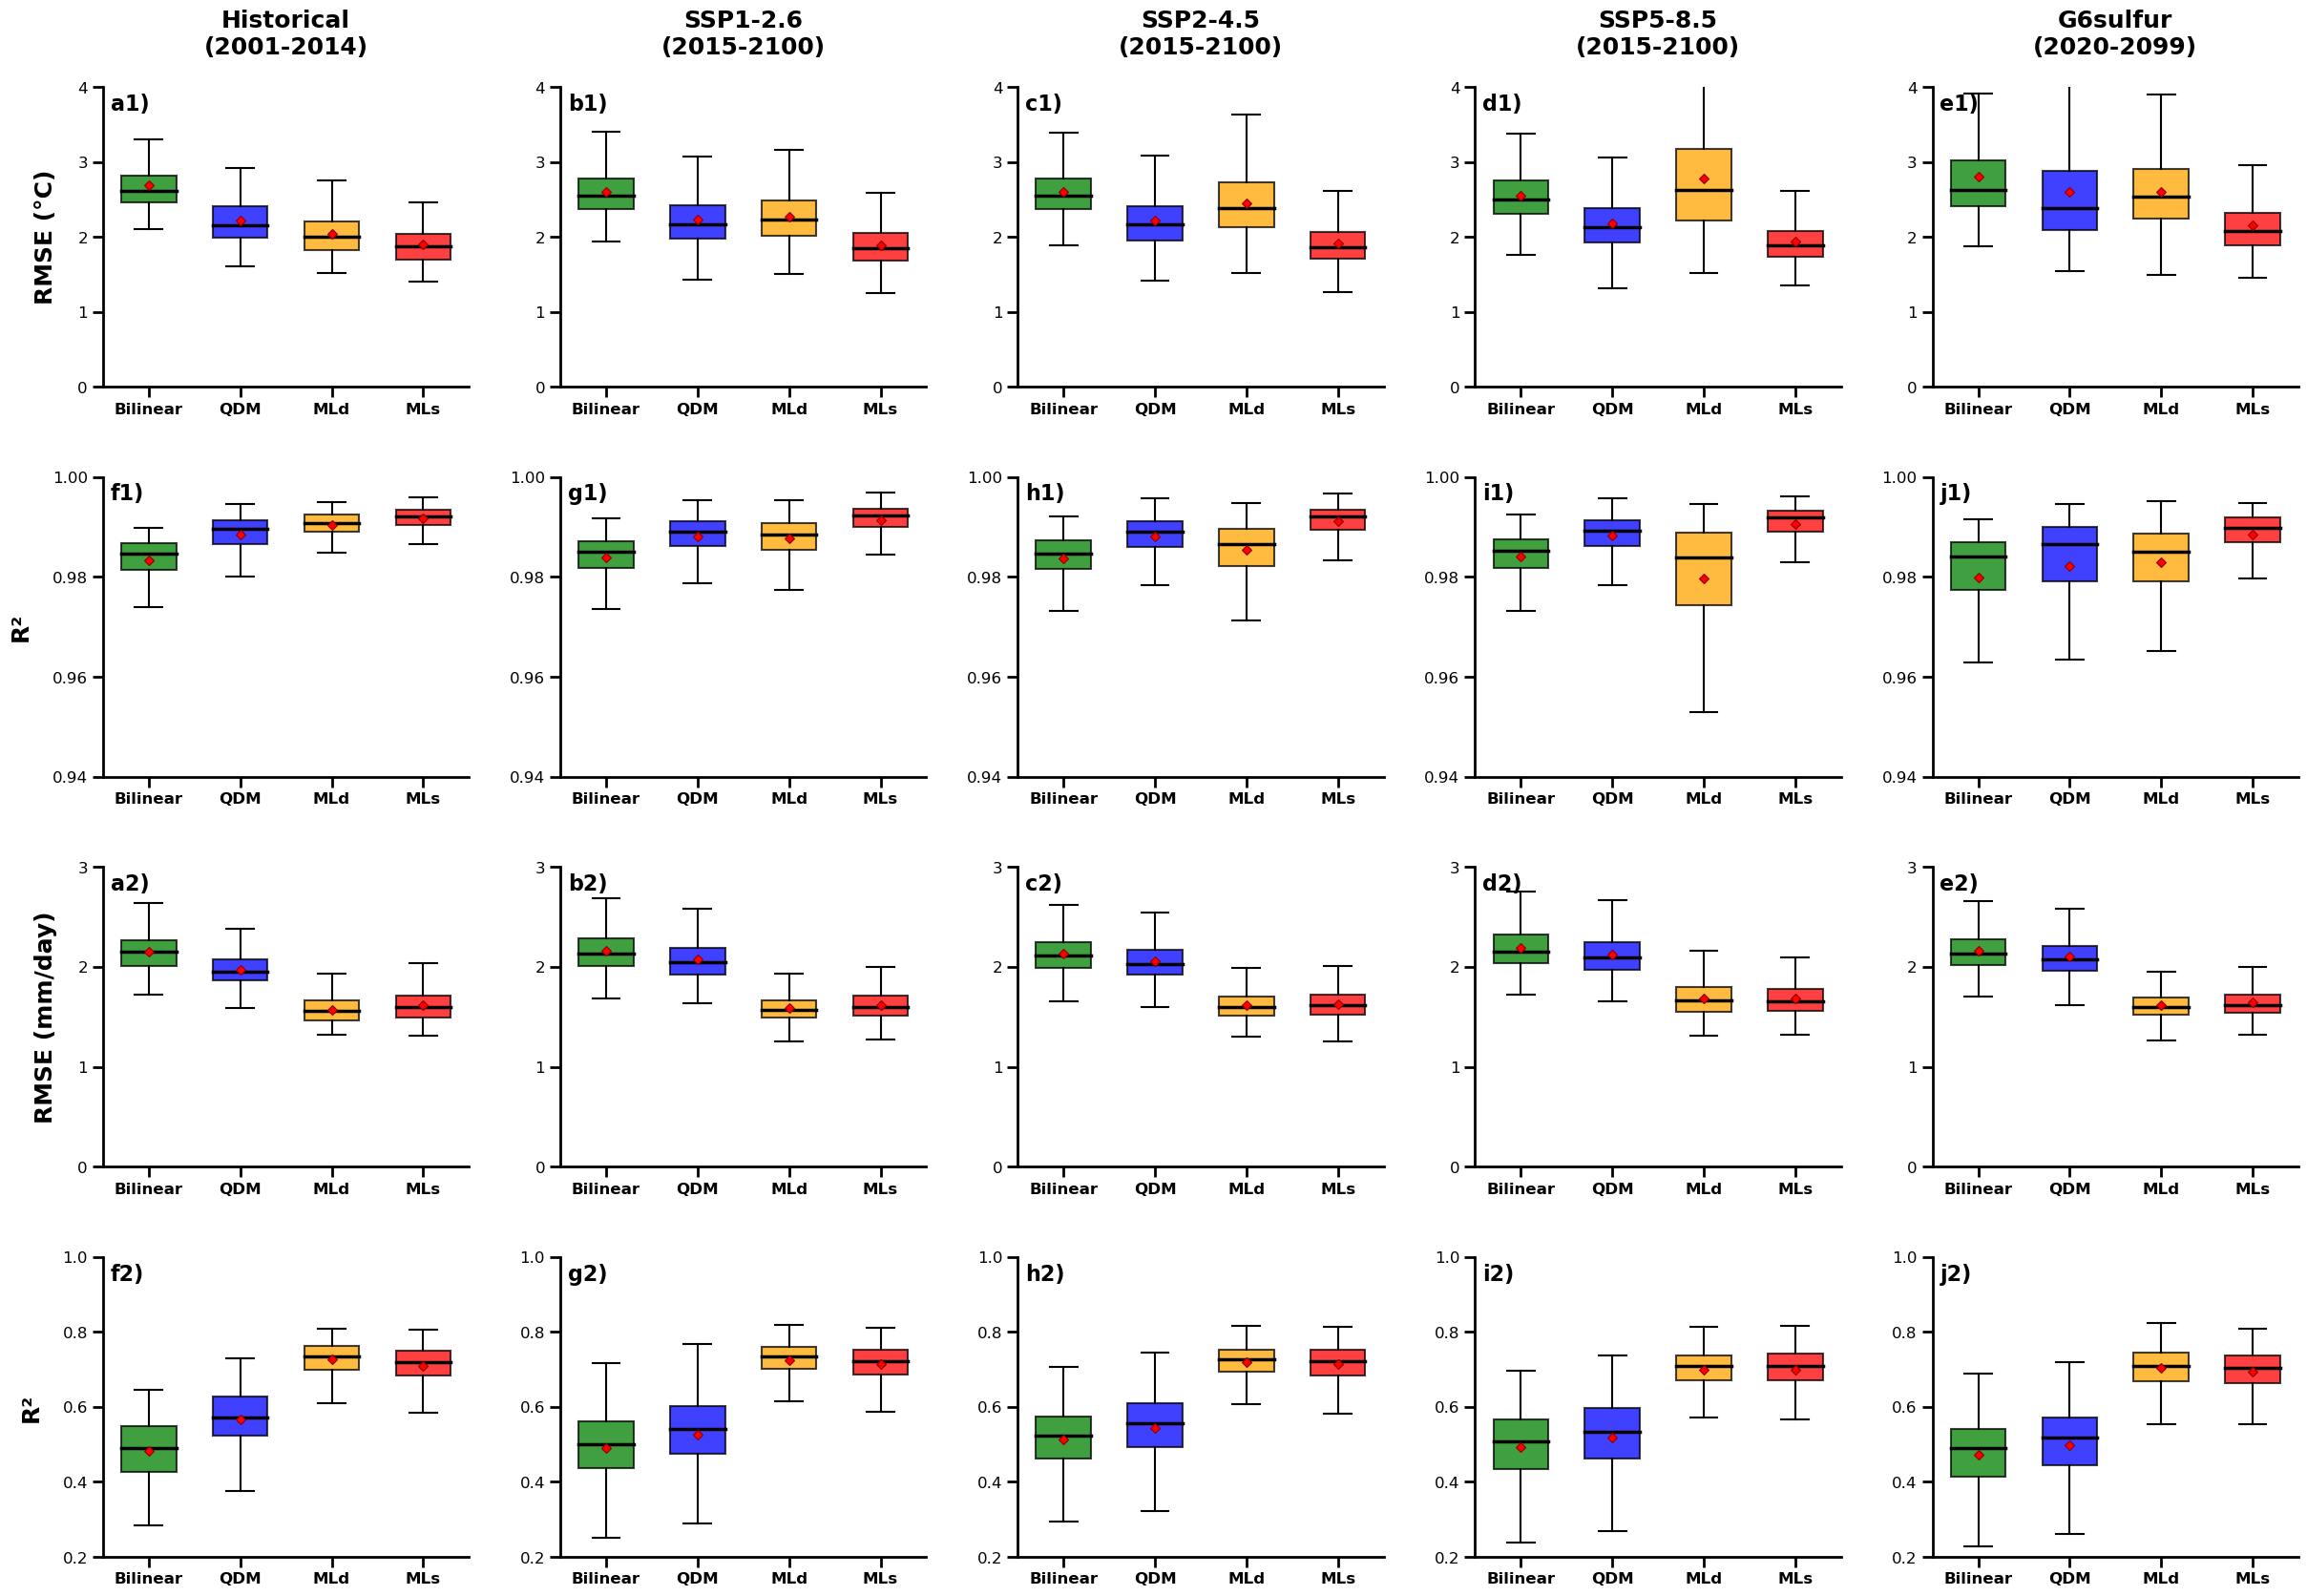

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

variables = ['tas', 'pr']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']

# Model configurations
models = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'zs_p': 'MLd',      
    'pld_res': 'MLs'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical\n(2001-2014)',
    'ssp126': 'SSP1-2.6\n(2015-2100)',
    'ssp245': 'SSP2-4.5\n(2015-2100)',
    'g6sulfur': 'G6sulfur\n(2020-2099)',
    'ssp585': 'SSP5-8.5\n(2015-2100)'
}

# Units for RMSE
var_units = {
    'tas': '°C',
    'pr': 'mm/day'
}

# Colors for models
model_colors = {
    'bilinear': 'green',    
    'qdm': 'blue',        
    'zs_p': 'orange',        
    'pld_res': 'red'      
}

# Y-axis configuration
y_axis_config = {
    'tas': {
        'rmse': {'lim': (0, 4), 'ticks': [0, 1, 2, 3, 4]},
        'r2': {'lim': (0.94, 1), 'ticks': [0.94, 0.96, 0.98, 1.0]}
    },
    'pr': {
        'rmse': {'lim': (0, 3), 'ticks': [0, 1, 2, 3]},
        'r2': {'lim': (0.2, 1), 'ticks': [0.2, 0.4, 0.6, 0.8, 1.0]}
    }
}

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_rmse_timeseries(predictions, groundtruth):
    """Calculate spatial RMSE for each time point."""
    n_time = predictions.shape[0]
    rmse_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
    
    return np.array(rmse_values)

def compute_spatial_r2_timeseries(predictions, groundtruth):
    """Calculate spatial R² for each time point."""
    n_time = predictions.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        ss_res = np.sum((gt_2d - pred_2d)**2)
        ss_tot = np.sum((gt_2d - np.mean(gt_2d))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# ----------------------------
# Load data and compute metrics
# ----------------------------
# Storage: metrics[var][scenario][model] = timeseries
metrics_rmse = {var: {scen: {} for scen in scenarios} for var in variables}
metrics_r2 = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    for scenario in scenarios:
        # Load main results (for bilinear and MLd)
        main_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        if main_file.exists():
            ds_main = xr.open_dataset(main_file)
            gt_data = ds_main['groundtruth'].values
            
            # Bilinear (input)
            if 'input' in ds_main:
                input_data = ds_main['input'].values
                metrics_rmse[var][scenario]['bilinear'] = compute_spatial_rmse_timeseries(input_data, gt_data)
                metrics_r2[var][scenario]['bilinear'] = compute_spatial_r2_timeseries(input_data, gt_data)
            
            # MLd (zscore_pixel) - Changed back to zscore_pixel
            if 'pred_zscore_pixel' in ds_main:
                pred_data = ds_main['pred_zscore_pixel'].values
                metrics_rmse[var][scenario]['zs_p'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
                metrics_r2[var][scenario]['zs_p'] = compute_spatial_r2_timeseries(pred_data, gt_data)
            
            ds_main.close()
        
        # Load QDM results
        qdm_file = results_dir / f"{var}_evaluation_{scenario}_qdm.nc"
        if qdm_file.exists():
            ds_qdm = xr.open_dataset(qdm_file)
            gt_data = ds_qdm['groundtruth'].values
            
            if 'pred_qdm' in ds_qdm:
                pred_data = ds_qdm['pred_qdm'].values
                metrics_rmse[var][scenario]['qdm'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
                metrics_r2[var][scenario]['qdm'] = compute_spatial_r2_timeseries(pred_data, gt_data)
            
            ds_qdm.close()
        
        # Load residual results (for MLs)
        residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if residual_file.exists():
            ds_residual = xr.open_dataset(residual_file)
            gt_data = ds_residual['groundtruth'].values
            
            if 'pred_grid' in ds_residual:
                pred_data = ds_residual['pred_grid'].values
                metrics_rmse[var][scenario]['pld_res'] = compute_spatial_rmse_timeseries(pred_data, gt_data)
                metrics_r2[var][scenario]['pld_res'] = compute_spatial_r2_timeseries(pred_data, gt_data)
            
            ds_residual.close()

# ----------------------------
# Create 4x5 visualization
# ----------------------------
fig, axes = plt.subplots(4, 5, figsize=(25, 20))

# Row configuration: (metric_type, variable)
# First two rows: tas (RMSE, R²), Last two rows: pr (RMSE, R²)
row_config = [
    ('rmse', 'tas'),  # Row 0: RMSE for temperature
    ('r2', 'tas'),    # Row 1: R² for temperature
    ('rmse', 'pr'),   # Row 2: RMSE for precipitation
    ('r2', 'pr')      # Row 3: R² for precipitation
]

# Panel labels: a1-j1 for tas, a2-j2 for pr
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

for row, (metric_type, var) in enumerate(row_config):
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        
        # Determine panel label
        if var == 'tas':
            panel_label = f"{letters[row * 5 + col]}1"
        else:
            panel_label = f"{letters[(row - 2) * 5 + col]}2"
        
        # Select appropriate metrics and config
        if metric_type == 'rmse':
            metrics = metrics_rmse
            ylabel = f'RMSE ({var_units[var]})'
            y_config = y_axis_config[var]['rmse']
        else:
            metrics = metrics_r2
            ylabel = 'R²'
            y_config = y_axis_config[var]['r2']
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        labels = []
        
        for i, (model_key, model_name) in enumerate(models.items()):
            if model_key in metrics[var][scenario]:
                box_data.append(metrics[var][scenario][model_key])
                positions.append(i + 1)
                colors.append(model_colors[model_key])
                labels.append(model_name)
        
        # Create box plot
        if len(box_data) > 0:
            bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                            patch_artist=True, showfliers=False,
                            medianprops=dict(color='black', linewidth=2.5),
                            boxprops=dict(linewidth=1.5),
                            whiskerprops=dict(linewidth=1.5),
                            capprops=dict(linewidth=1.5))
            
            # Color the boxes
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.75)
            
            # Add mean marker (red diamond)
            for i, data_values in enumerate(box_data):
                mean_val = np.mean(data_values)
                ax.plot(positions[i], mean_val, 'D', color='red', 
                       markersize=5, zorder=10, markeredgecolor='darkred', 
                       markeredgewidth=0.8)
        
        # Add panel label
        ax.text(0.02, 0.98, f'{panel_label})', 
               transform=ax.transAxes, fontsize=16, fontweight='bold',
               va='top', ha='left')
        
        # Formatting
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, fontsize=14, fontweight='bold')

        
        ax.set_ylim(y_config['lim'])
        ax.set_yticks(y_config['ticks'])
        
        # Y-axis label on leftmost column
        if col == 0:
            ax.set_ylabel(ylabel, fontsize=18, fontweight='bold', labelpad=15)
        
        # Scenario title on top row only
        if row == 0:
            ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=25)
        
        # Spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        ax.tick_params(axis='both', which='major', labelsize=12, length=8, width=2, colors='black')

plt.subplots_adjust(hspace=0.3, wspace=0.25, left=0.06, right=0.98)

# Save figure
output_file = figures_dir / "fig2.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()